In [1]:


import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
# Right after importing seaborn (could also use 'whitegrid')
sns.set_theme(style='darkgrid', context='talk')

import warnings
warnings.filterwarnings('ignore')

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from numpy import sqrt

In [2]:
data=pd.read_csv('data_cleaned.csv', parse_dates=['date'], index_col=0)
data.head()

,order_id,date,item_code,quantity,unit_price_vat_excl,unit_cogs,net_revenue,gross_revenue,margin_revenue,country,item_name,style,name,group0,group1,category
0,1.900052e+09,2019-06-04,ZB00025746,1,9.412096,0.000000,9.412096,0.000000,9.412096,Romania,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
1,1.900101e+09,2019-07-15,ZB00025746,1,8.648837,5.393411,8.648837,5.393411,3.255426,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
2,1.900107e+09,2019-07-24,ZB00025746,1,8.648837,5.458527,8.648837,5.458527,3.190310,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
3,1.900111e+09,2019-08-01,ZB00025746,1,8.648837,5.440310,8.648837,5.440310,3.208527,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
4,1.900052e+09,2019-06-04,ZB00022010,1,12.784729,4.087597,12.784729,4.087597,8.697132,Romania,NK MERC LT GRD,sp2120-703,Nike,Equipment,Guards,football


In [4]:
data=data[data['country']=='Czech Republic']
data.head()

,order_id,date,item_code,quantity,unit_price_vat_excl,unit_cogs,net_revenue,gross_revenue,margin_revenue,country,item_name,style,name,group0,group1,category
1,1.900101e+09,2019-07-15,ZB00025746,1,8.648837,5.393411,8.648837,5.393411,3.255426,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
2,1.900107e+09,2019-07-24,ZB00025746,1,8.648837,5.458527,8.648837,5.458527,3.190310,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
3,1.900111e+09,2019-08-01,ZB00025746,1,8.648837,5.440310,8.648837,5.440310,3.208527,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
5,1.900082e+09,2019-06-05,ZB00022010,1,17.297674,4.087597,17.297674,4.087597,13.210078,Czech Republic,NK MERC LT GRD,sp2120-703,Nike,Equipment,Guards,football
9,1.900110e+09,2019-07-30,ZB00004531,1,12.268605,6.804651,12.268605,6.804651,5.463953,Czech Republic,U NK DRY CUSH CREW 3PR,sx5547-010,Nike,Apparel,Socks,football


In [5]:
def select_series(data, time_period='week', revenue='net'):
    time_periods = {
        'day': 'D',
        'week': 'W',
        'month': 'M'}
    
    revenue_cat = {
        'net':'net_revenue',
        'gross':'gross_revenue',
        'margin':'margin_revenue'}
    
    data = data.set_index('date')
    data = data[revenue_cat[revenue]].resample(time_periods[time_period]).sum()
    data = pd.DataFrame(data).reset_index()
    return data

In [7]:
weekly_sales=select_series(data)
weekly_sales.columns=['ds', 'y']
weekly_sales.ds=pd.to_datetime(weekly_sales['ds'])
weekly_sales.sort_values('ds')
weekly_sales.head()

,ds,y
0,2019-06-02,2838.778531
1,2019-06-09,91631.367623
2,2019-06-16,65415.484743
3,2019-06-23,94351.079276
4,2019-06-30,62383.466525


In [8]:
weekly_sales.shape

(102, 2)

In [9]:
#daily_sales['y']=np.log(daily_sales['y'])

In [11]:

train_df=weekly_sales[:int(weekly_sales.shape[0]*0.75)]

test_df=weekly_sales[int(weekly_sales.shape[0]*0.75):]
print(train_df.shape)
print(test_df.shape)

(76, 2)
(26, 2)


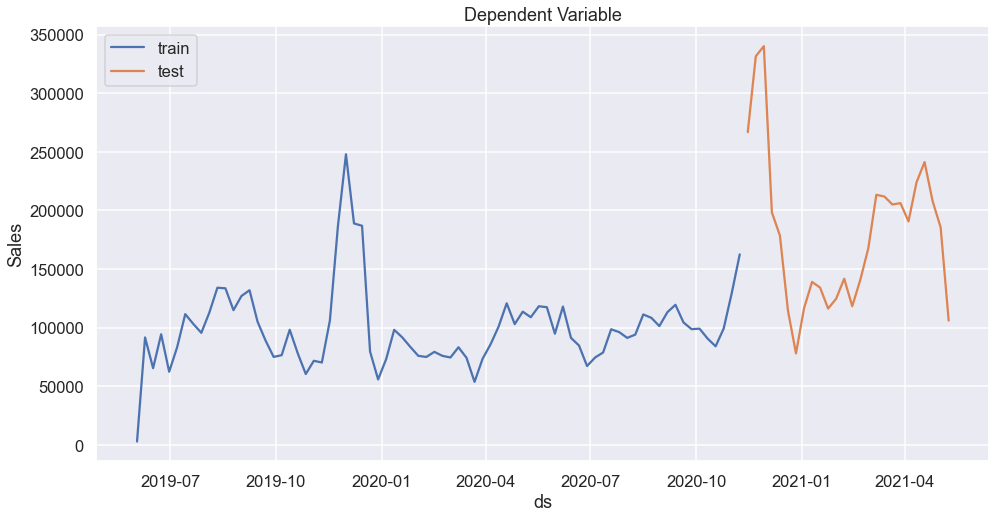

In [12]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x='ds', y='y', label='train', data=train_df, ax=ax)
sns.lineplot(x='ds', y='y', label='test', data=test_df, ax=ax)

ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='Sales');

In [13]:
#training the model on training set
from prophet.plot import add_changepoints_to_plot

model=Prophet(growth='linear',weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.001)
model.add_seasonality( name='monthly', period=30.5, fourier_order=5)
model.fit(train_df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [14]:
future=model.make_future_dataframe(periods=test_df.shape[0]+5, freq='W')
forecast=model.predict(future)

In [15]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-02,95073.686488,73581.055123,144164.035804,95073.686488,95073.686488,13336.671681,13336.671681,13336.671681,13336.671681,13336.671681,13336.671681,0.0,0.0,0.0,108410.358169
1,2019-06-09,95198.981794,77113.502264,147219.607709,95198.981794,95198.981794,18339.329266,18339.329266,18339.329266,18339.329266,18339.329266,18339.329266,0.0,0.0,0.0,113538.311060
2,2019-06-16,95324.277100,67917.786492,139871.861355,95324.277100,95324.277100,9428.918904,9428.918904,9428.918904,9428.918904,9428.918904,9428.918904,0.0,0.0,0.0,104753.196004
3,2019-06-23,95449.572408,57854.738427,132979.993126,95449.572408,95449.572408,-1099.143800,-1099.143800,-1099.143800,-1099.143800,-1099.143800,-1099.143800,0.0,0.0,0.0,94350.428608
4,2019-06-30,95574.867715,51221.439964,126576.847123,95574.867715,95574.867715,-7268.897117,-7268.897117,-7268.897117,-7268.897117,-7268.897117,-7268.897117,0.0,0.0,0.0,88305.970598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,2021-05-16,107853.808128,85851.028174,158239.567718,107853.805586,107853.810816,15426.322072,15426.322072,15426.322072,15426.322072,15426.322072,15426.322072,0.0,0.0,0.0,123280.130200
103,2021-05-23,107979.103441,54156.348817,129479.590751,107979.100719,107979.106316,-15564.286983,-15564.286983,-15564.286983,-15564.286983,-15564.286983,-15564.286983,0.0,0.0,0.0,92414.816458
104,2021-05-30,108104.398754,35398.997027,109478.402858,108104.395862,108104.401757,-36111.273557,-36111.273557,-36111.273557,-36111.273557,-36111.273557,-36111.273557,0.0,0.0,0.0,71993.125197
105,2021-06-06,108229.694066,45739.582530,121336.267371,108229.691040,108229.697243,-24792.615638,-24792.615638,-24792.615638,-24792.615638,-24792.615638,-24792.615638,0.0,0.0,0.0,83437.078428


In [16]:
# We want to look at yhat, yhat_lower, and yhat_upper only. 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-06-02,108410.358169,73581.055123,144164.035804
1,2019-06-09,113538.311060,77113.502264,147219.607709
2,2019-06-16,104753.196004,67917.786492,139871.861355
3,2019-06-23,94350.428608,57854.738427,132979.993126
4,2019-06-30,88305.970598,51221.439964,126576.847123


In [17]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
102,2021-05-16,107853.808128,85851.028174,158239.567718,107853.805586,107853.810816,15426.322072,15426.322072,15426.322072,15426.322072,15426.322072,15426.322072,0.0,0.0,0.0,123280.130200
103,2021-05-23,107979.103441,54156.348817,129479.590751,107979.100719,107979.106316,-15564.286983,-15564.286983,-15564.286983,-15564.286983,-15564.286983,-15564.286983,0.0,0.0,0.0,92414.816458
104,2021-05-30,108104.398754,35398.997027,109478.402858,108104.395862,108104.401757,-36111.273557,-36111.273557,-36111.273557,-36111.273557,-36111.273557,-36111.273557,0.0,0.0,0.0,71993.125197
105,2021-06-06,108229.694066,45739.582530,121336.267371,108229.691040,108229.697243,-24792.615638,-24792.615638,-24792.615638,-24792.615638,-24792.615638,-24792.615638,0.0,0.0,0.0,83437.078428
106,2021-06-13,108354.989379,66452.433039,142838.705659,108354.986194,108354.992693,-5519.156297,-5519.156297,-5519.156297,-5519.156297,-5519.156297,-5519.156297,0.0,0.0,0.0,102835.833082


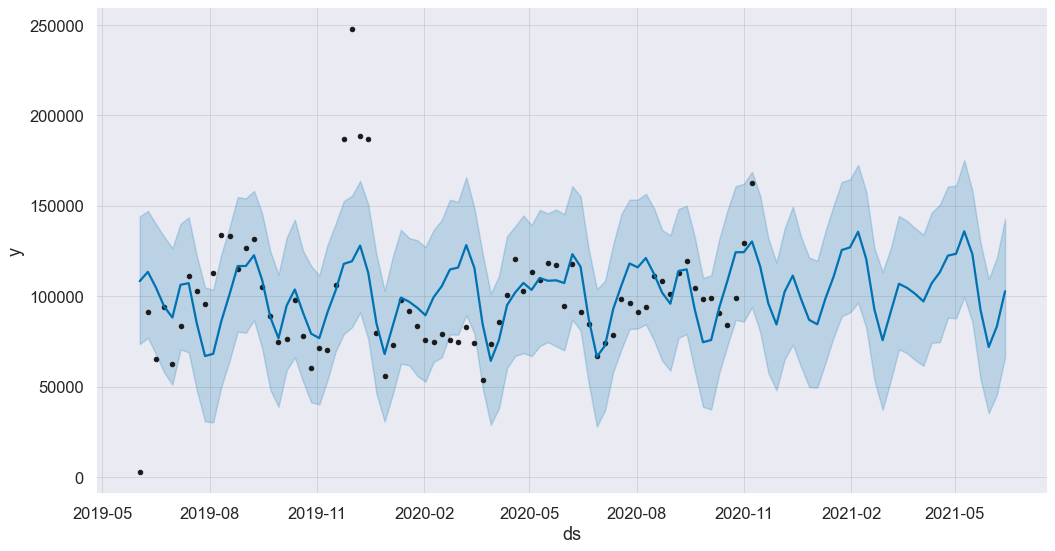

In [18]:
#ploting the forecast
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=model.plot(forecast, ax=ax)
plt.show()

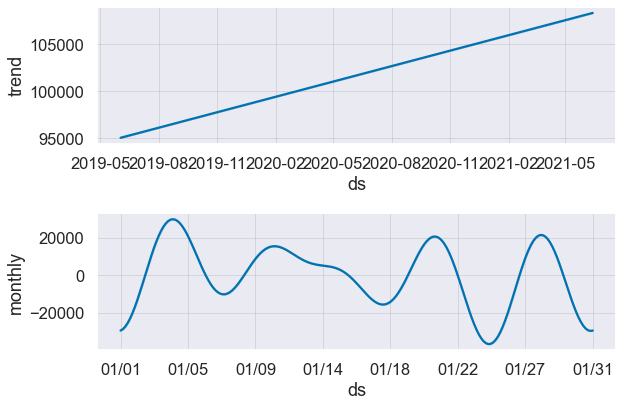

In [19]:
# ploting model components
model.plot_components(forecast)

plt.show()

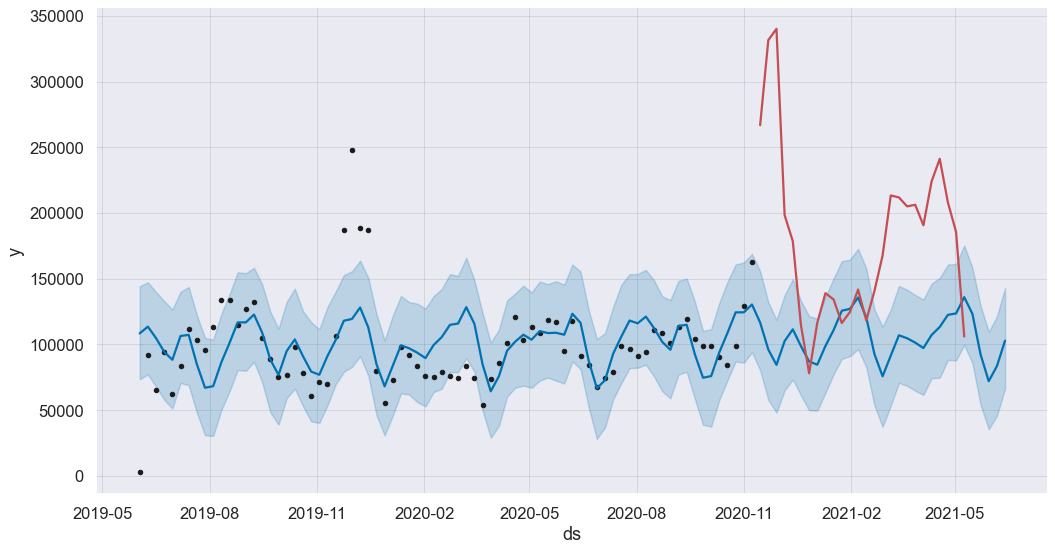

In [20]:
 # comparing Forecast to Actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig=model.plot(forecast, ax=ax)
ax.plot(test_df.ds, test_df.y, color='r')



In [21]:
x_test_forecast=model.predict(test_df)
x_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
19,2021-03-28,101351.323114,63374.475438,141466.076961
20,2021-04-04,97209.569297,59195.528575,133456.926112
21,2021-04-11,107167.585442,71553.753839,148677.149882
22,2021-04-18,113264.329352,76681.273798,149673.785729
23,2021-04-25,122505.359259,86475.832845,159370.547827
24,2021-05-02,123555.484062,88081.081905,159252.390186
25,2021-05-09,135975.909307,101126.728547,173908.934237


Text(0.5, 1.0, 'Forecast VS Actual')

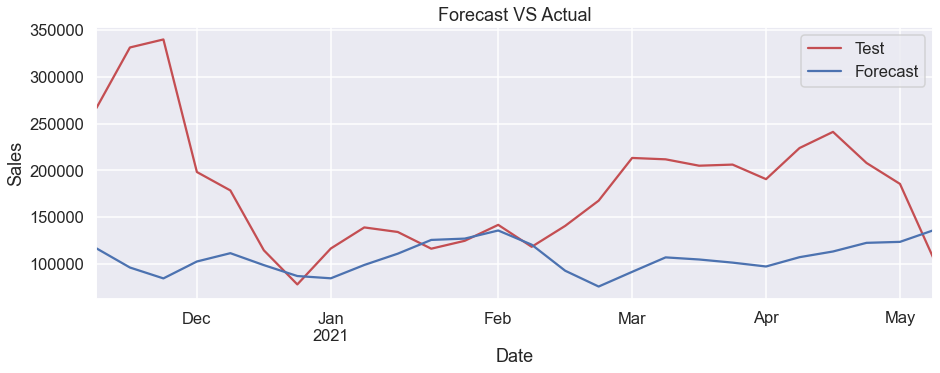

In [22]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(5)
f.set_figwidth(15)
test_df.plot(x='ds', y='y', color='r', label='Test', ax=ax)
x_test_forecast.plot(x='ds', y='yhat', label='Forecast', ax=ax)
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Forecast VS Actual')



Text(0.5, 1.0, 'One month Forecast Vs Actual, April 07 to May 6 , 2021')

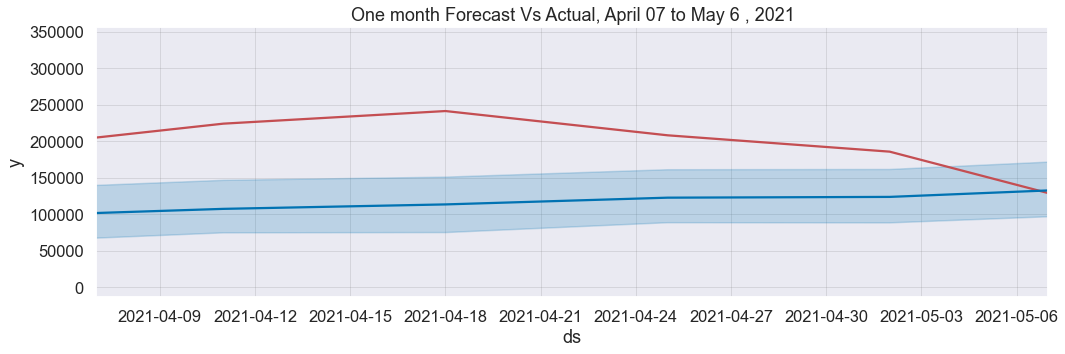

In [23]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-04-07', upper='2021-05-07')

plt.title('One month Forecast Vs Actual, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One month Forecast, May 07 to June 6, 2021')

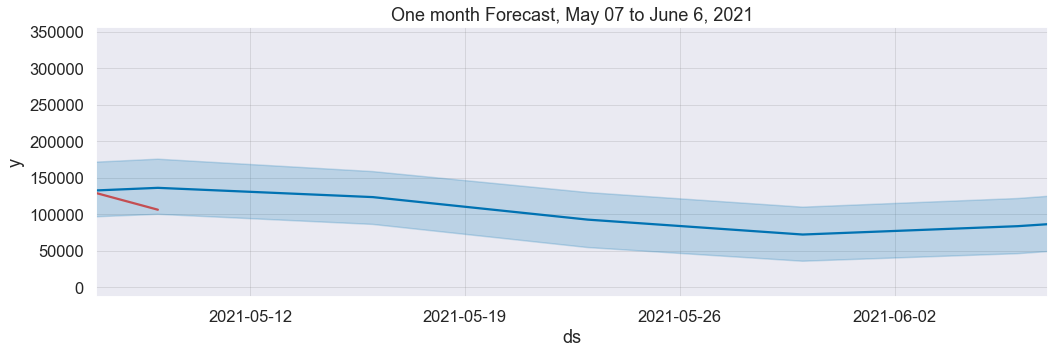

In [24]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-05-07', upper='2021-06-07')

plt.title('One month Forecast, May 07 to June 6, 2021')

Text(0.5, 1.0, 'One week Forecast Vs Actual, March 19 to 25, 2021')

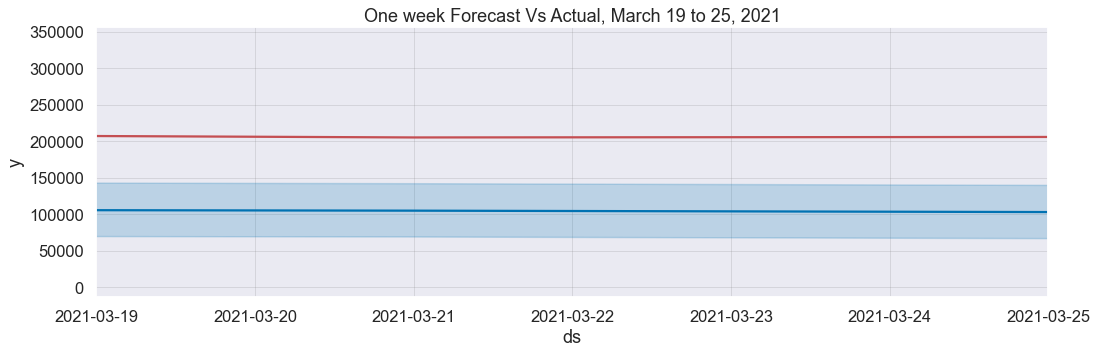

In [25]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-03-19', upper='2021-03-25')

plt.title('One week Forecast Vs Actual, March 19 to 25, 2021')


In [26]:
# Means Squared Error and RSME
predictions=forecast.yhat[-26:]
mse=mean_squared_error(test_df.y, predictions)
rmse=sqrt(mean_squared_error(test_df.y, predictions))
print('MSE: ', mse)
print('RMSE: ', rmse)

#Mean absolute percentage error (mape)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Cross Validation
df_cv=cross_validation(model=model, horizon='35 days', initial='350', period='56 days')

mape=mean_absolute_percentage_error(df_cv.y, df_cv.yhat)
print('MAPE: ', mape)

# https://www.kaggle.com/robikscube/time-series-forecasting-with-prophet

INFO:fbprophet:Making 9 forecasts with cutoffs between 2019-07-14 00:00:00 and 2020-10-04 00:00:00


MSE:  10853503048.989878
RMSE:  104180.14709621924


INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.



MAPE:  87.5765333794156


In [27]:
df_cv.head(20)


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-07-21,-1.109819e+06,-1.109819e+06,-1.109819e+06,103197.193966,2019-07-14
1,2019-07-28,6.212492e+05,6.212492e+05,6.212492e+05,95561.567246,2019-07-14
2,2019-08-04,-1.558613e+04,-1.558613e+04,-1.558613e+04,112873.697051,2019-07-14
3,2019-08-11,1.708163e+05,1.708163e+05,1.708163e+05,134045.352453,2019-07-14
4,2019-08-18,-3.187347e+05,-3.187347e+05,-3.187347e+05,133544.713305,2019-07-14
5,2019-09-15,1.667664e+05,1.507817e+05,1.812715e+05,105011.608709,2019-09-08
6,2019-09-22,1.869947e+05,1.712307e+05,2.027377e+05,88903.134315,2019-09-08
7,2019-09-29,1.634047e+05,1.476148e+05,1.784104e+05,75018.566899,2019-09-08
8,2019-10-06,1.792854e+05,1.640495e+05,1.951129e+05,76507.403705,2019-09-08
9,2019-10-13,1.994446e+05,1.851102e+05,2.150717e+05,98192.588937,2019-09-08


In [28]:
df_cv.tail(25)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
20,2020-03-01,146306.572864,101449.340212,189939.608776,74523.092163,2020-02-23
21,2020-03-08,155922.545773,113016.398639,202058.607959,83251.569905,2020-02-23
22,2020-03-15,143537.375105,98650.604069,188566.965648,74252.366883,2020-02-23
23,2020-03-22,95000.292546,51177.967588,140517.798683,53749.819464,2020-02-23
24,2020-03-29,68354.822037,23922.279351,116181.333177,73413.364688,2020-02-23
25,2020-04-26,112114.962215,61107.934673,162320.121346,103001.099476,2020-04-19
26,2020-05-03,95854.656775,47129.059051,141063.010443,113615.118824,2020-04-19
27,2020-05-10,100916.631856,54306.929204,148867.324485,108880.910920,2020-04-19
28,2020-05-17,101418.658600,52421.981156,148629.711104,118226.008560,2020-04-19
29,2020-05-24,104606.759941,53953.232413,154052.399670,117434.845403,2020-04-19


In [29]:
### Performance Metrics
from fbprophet.diagnostics import performance_metrics
df_perf = performance_metrics(df_cv, rolling_window=0.1)
df_perf

,horizon,mse,rmse,mae,mape,mdape,coverage
0,7 days,1.653517e+11,406634.559943,165554.597614,1.691693,0.588076,0.444444
1,14 days,3.292710e+10,181458.271357,93496.711093,0.997667,0.381203,0.555556
2,21 days,4.105372e+09,64073.175663,50427.916349,0.520314,0.343047,0.444444
3,28 days,4.856832e+09,69690.976269,50117.198112,0.472661,0.274317,0.555556
4,35 days,2.510054e+10,158431.503665,85734.006011,0.696491,0.238148,0.555556


In [30]:
df_cv2=cross_validation(model, horizon='26 days', initial=750, period='56 days')

mape=mean_absolute_percentage_error(df_cv.y, df_cv.yhat)
print('MAPE: ', mape)

INFO:fbprophet:Making 9 forecasts with cutoffs between 2019-07-23 00:00:00 and 2020-10-13 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.



MAPE:  87.5765333794156


In [31]:
df_cv2

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-07-28,1.311145e+06,1.311136e+06,1.311152e+06,95561.567246,2019-07-23
1,2019-08-04,-5.762497e+04,-5.765636e+04,-5.759703e+04,112873.697051,2019-07-23
2,2019-08-11,-9.017713e+05,-9.018319e+05,-9.017177e+05,134045.352453,2019-07-23
3,2019-08-18,-8.809550e+05,-8.810556e+05,-8.808661e+05,133544.713305,2019-07-23
4,2019-09-22,1.574449e+05,1.395309e+05,1.770445e+05,88903.134315,2019-09-17
5,2019-09-29,1.398540e+05,1.192484e+05,1.587725e+05,75018.566899,2019-09-17
6,2019-10-06,1.621737e+05,1.426619e+05,1.821297e+05,76507.403705,2019-09-17
7,2019-10-13,1.764537e+05,1.564710e+05,1.960991e+05,98192.588937,2019-09-17
8,2019-11-17,1.182078e+05,8.671477e+04,1.495354e+05,106114.444285,2019-11-12
9,2019-11-24,1.160432e+05,8.332437e+04,1.470755e+05,186713.817329,2019-11-12


Text(0.5, 1.0, 'Forecast Vs Actual after Cross Validation')

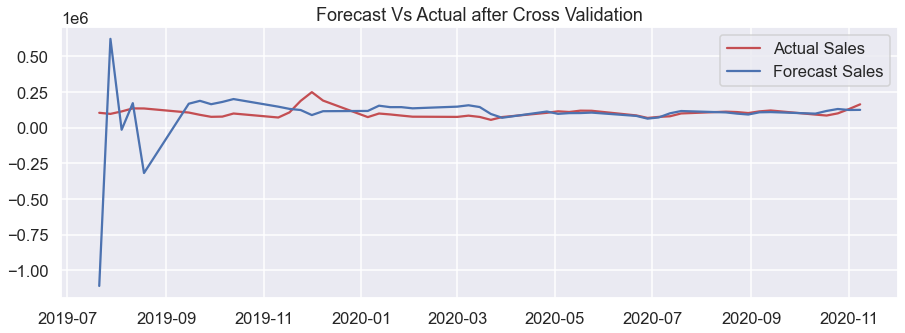

In [32]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(df_cv['ds'], df_cv['y'], color='r', label='Actual Sales')
ax.plot(df_cv['ds'], df_cv['yhat'], color='b', label='Forecast Sales')
plt.legend()



plt.title('Forecast Vs Actual after Cross Validation')

# Hyperparameter tuning


In [49]:
import itertools
param_grid = {'seasonality_mode':('multiplicative','additive'),  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
             'n_changepoints' : [3, 6, 9, 12, 15, 18, 21, 24, 25, 30]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    cutoffs=pd.to_datetime(['2020-03-03','2020-04-28'])
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2684c8d30>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2687b2d00>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. R

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2683c42e0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2694ce880>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concur

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2683ddee0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2683e58e0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. R

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26bfbbf70>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26842cca0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concur

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26bfcd6d0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26bfc4670>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. R

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc29e0f0820>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26843b2e0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concur

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26bfcdac0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26d925fd0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. R

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc269478970>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26dced3a0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concur

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26843b370>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26bfc4670>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. R

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26d04d9d0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26d91d2b0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concur

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26841cd00>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2687b2d00>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. R

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26dc500d0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2684b97f0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concur

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2683eb490>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26843bfa0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. R

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2683c4940>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2694f2f10>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concur

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26842cd00>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26d976f10>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. R

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc269478970>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26dc2c790>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concur

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26d91dfd0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc26bfcd6d0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. R

    seasonality_mode  changepoint_prior_scale  seasonality_prior_scale  \
0     multiplicative                    0.001                     0.01   
1     multiplicative                    0.001                     0.01   
2     multiplicative                    0.001                     0.01   
3     multiplicative                    0.001                     0.01   
4     multiplicative                    0.001                     0.01   
..               ...                      ...                      ...   
315         additive                    0.500                    10.00   
316         additive                    0.500                    10.00   
317         additive                    0.500                    10.00   
318         additive                    0.500                    10.00   
319         additive                    0.500                    10.00   

     n_changepoints          rmse  
0                 3  28631.683574  
1                 6  29592.574714  
2  

In [50]:
tuning_results.sort_values(by=['rmse'])

,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,n_changepoints,rmse
200,additive,0.01,0.01,3,28043.729468
210,additive,0.01,0.10,3,28043.729468
60,multiplicative,0.01,1.00,3,28043.729468
220,additive,0.01,1.00,3,28043.729468
70,multiplicative,0.01,10.00,3,28043.729468
...,...,...,...,...,...
307,additive,0.50,1.00,24,32822.350229
297,additive,0.50,0.10,24,32822.350229
147,multiplicative,0.50,1.00,24,32822.350229
287,additive,0.50,0.01,24,32822.350229


In [91]:
final_model=Prophet(growth='linear',weekly_seasonality=True, daily_seasonality=True, changepoint_prior_scale=0.01,seasonality_prior_scale=0.500)
final_model.add_seasonality( name='monthly', period=30.5, fourier_order=5)
final_model.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [92]:
future=final_model.make_future_dataframe(periods=test_df.shape[0]+5, freq='W')
final_forecast=final_model.predict(future)

In [93]:
final_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-06-02,106826.185483,68702.677600,147438.021043
1,2019-06-09,111341.662089,72579.844844,149827.149667
2,2019-06-16,102510.828983,64041.554725,140794.126893
3,2019-06-23,93351.704740,53316.075666,129906.793096
4,2019-06-30,88045.074243,50776.484008,128511.973914


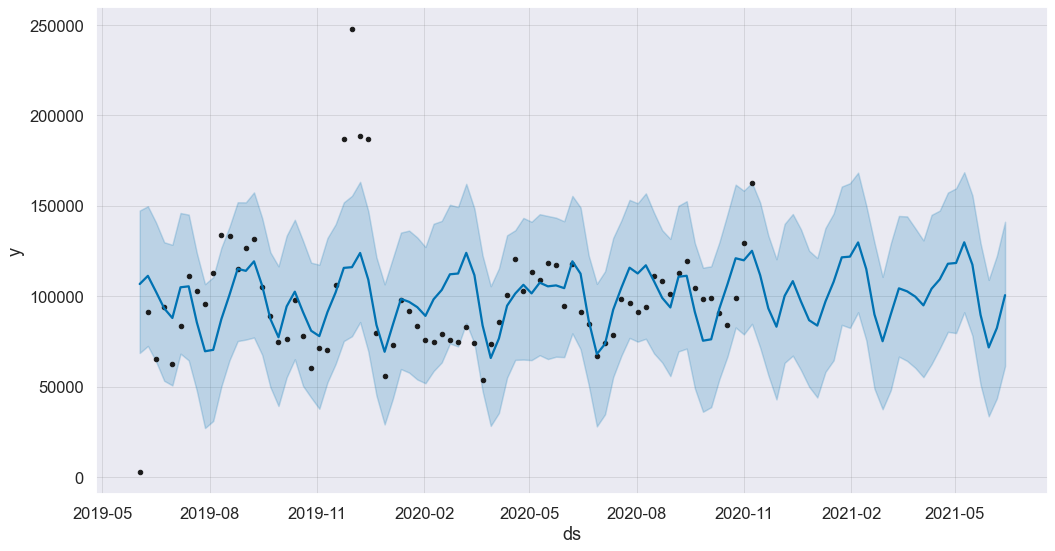

In [94]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=final_model.plot(final_forecast, ax=ax)
plt.show()

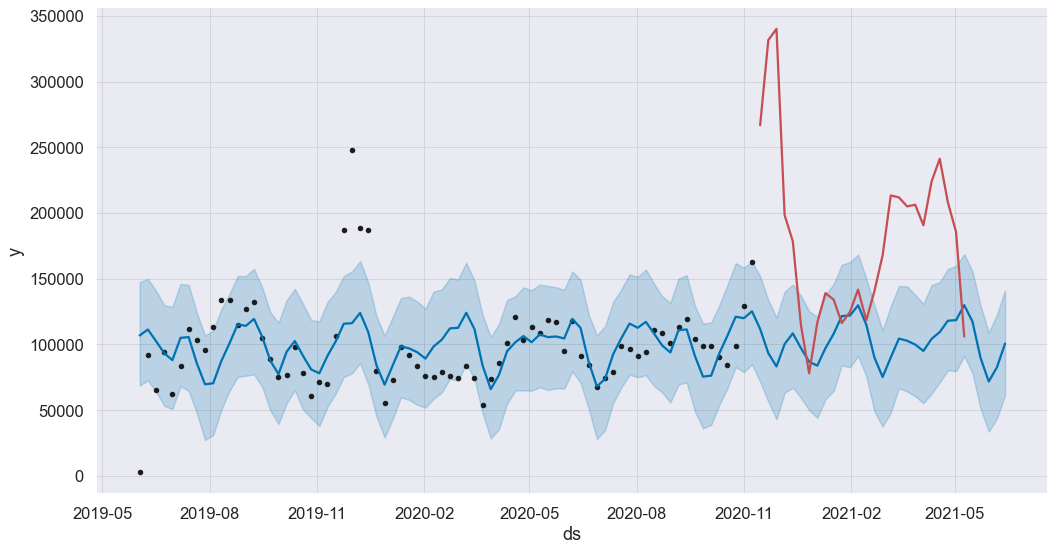

In [95]:
 # comparing Forecast to Actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig=final_model.plot(final_forecast, ax=ax)
ax.plot(test_df.ds, test_df.y, color='r')

Text(0.5, 1.0, 'Forecast VS Actual')

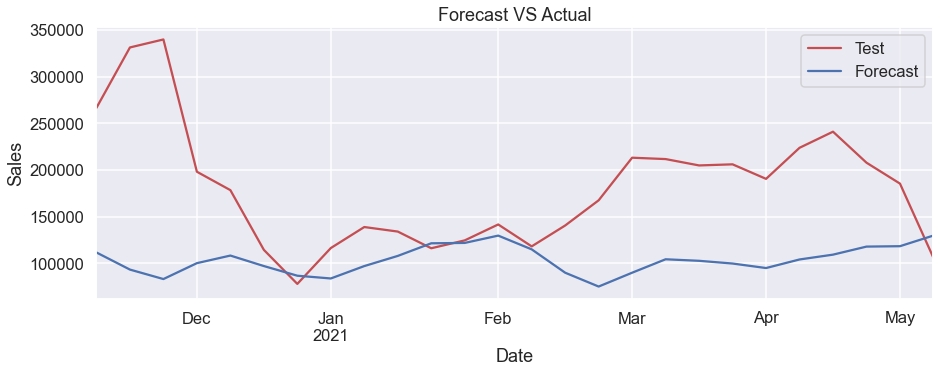

In [96]:
# Plot the forecast with the actuals
x_test_forecast=final_model.predict(test_df)

f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(5)
f.set_figwidth(15)
test_df.plot(x='ds', y='y', color='r', label='Test', ax=ax)
x_test_forecast.plot(x='ds', y='yhat', label='Forecast', ax=ax)
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Forecast VS Actual')

In [97]:
mape=mean_absolute_percentage_error(test_df.y, x_test_forecast.yhat)
print('MAPE: ', mape)

MAPE:  37.58730407829706


Text(0.5, 1.0, 'One month Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

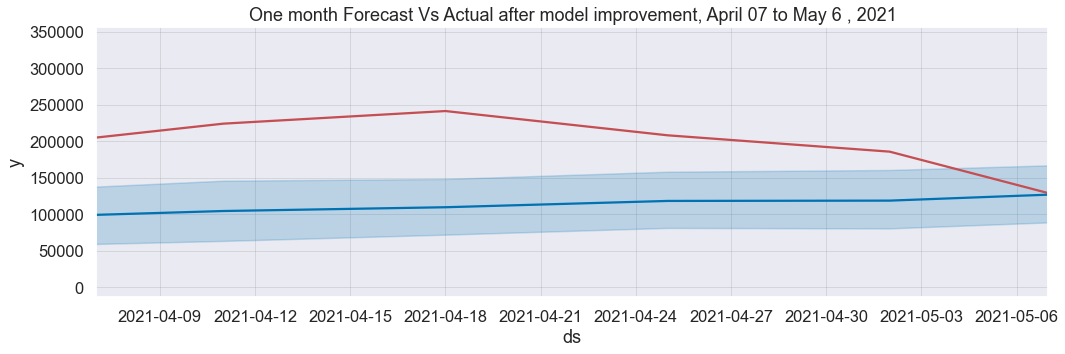

In [98]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-04-07', upper='2021-05-07')

plt.title('One month Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One week Forecast Vs Actual, March 19 to 25, 2021')

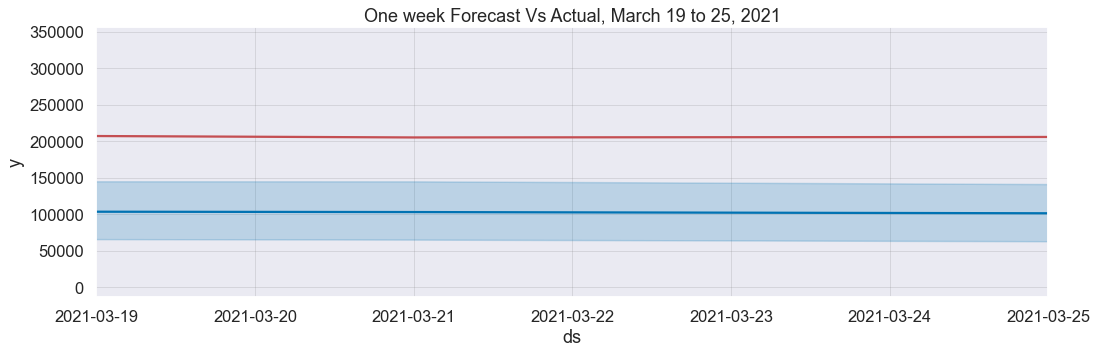

In [99]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-03-19', upper='2021-03-25')

plt.title('One week Forecast Vs Actual, March 19 to 25, 2021')

Text(0.5, 1.0, 'One month Forecast, May 07 to June 6, 2021')

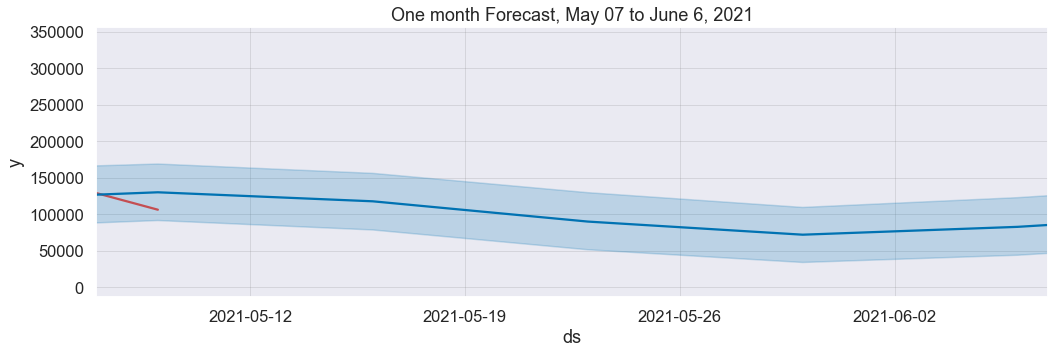

In [100]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-05-07', upper='2021-06-07')

plt.title('One month Forecast, May 07 to June 6, 2021')

In [101]:
forecast_one=forecast[['ds', 'yhat']]
forecast_two=final_forecast[['ds', 'yhat']]

In [102]:
forecast_one.columns=['ds', 'yhat_one']
forecast_two.columns=['ds', 'yhat_two']

In [103]:
forecast_combined=pd.merge(forecast_one, forecast_two, on='ds')

In [104]:
forecast_combined.head()

,ds,yhat_one,yhat_two
0,2019-06-02,108410.358169,106826.185483
1,2019-06-09,113538.311060,111341.662089
2,2019-06-16,104753.196004,102510.828983
3,2019-06-23,94350.428608,93351.704740
4,2019-06-30,88305.970598,88045.074243


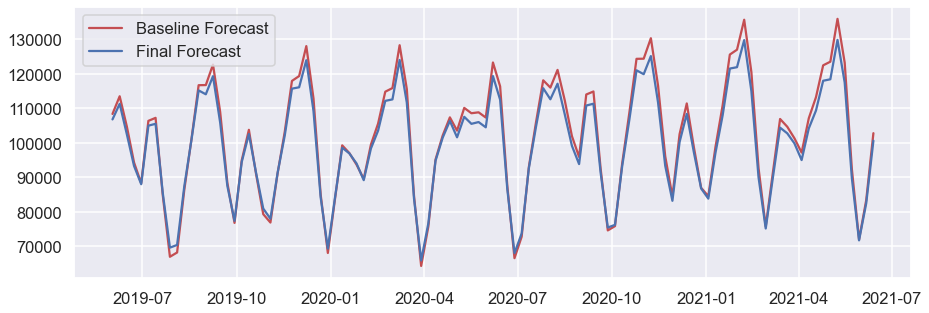

In [105]:
# Comparing the final forecast with the baseline forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(forecast_combined['ds'], forecast_combined['yhat_one'], color='r', label='Baseline Forecast')
ax.plot(forecast_combined['ds'], forecast_combined['yhat_two'], color='b', label='Final Forecast')
plt.legend()
plt.show()
